# Part 3: Raster Data Processing in Python

Handling geospatial raster data in Python is best done using these packages:
* "rasterio" for reading and writing raster files (e.g. .tiff)
* "numpy" for performing raster calculations (e.g. calcualate the NDVI)

There are also Python bindings directly based on gdal, but they are less "pythonic". 

In [1]:
import rasterio
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

You can use NASA’s Earthdata Search website to discover data. Landsat images are organized by ‘path’ and ‘row’. We’ve chosen a scenes from path 42, row 34, that doesn’t have many clouds present (LC08_L1TP_042034_20170616_20170629_01_T1). Note that ‘T1’ stands for ‘Tier 1’ (for analytic use), and ‘RT’ stands for ‘Real-time’, for which quality control is not as rigorous. Read more about the various Landsat formats and collections here. ​ At first glance it seems that you can find this data on both AWS or Google Cloud, for example look at the band 4 image for the date we selected: ​

http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF ​ ​

Or, the same file is available on Google Cloud storage: ​

https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF



In [2]:
print('Landsat on Google:')
filepath = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'
with rasterio.open(filepath) as src:
    print(src.profile)

Landsat on Google:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7821, 'height': 7951, 'count': 1, 'crs': CRS.from_dict(init='epsg:32611'), 'transform': Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [3]:
print('Landsat on AWS:')
filepath = 'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'
with rasterio.open(filepath) as src:
    print(src.profile)

Landsat on AWS:


ModuleNotFoundError: No module named 'boto3'

__Tipp__:

"Blocksize" refers to the size of the chunks that the raster is split into when it is written to the hard disk. In order to improve I/O performance when reading raster files, it is best to split big raster data sets using this blocksize because that enables continous reading. 

## Reading a spectral band within a bounding box

In [143]:
with rasterio.open(filepath) as src:
    band1 = src.read(1)
    affine = src.transform

In [144]:
affine

Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0)

Text(0, 0.5, 'Row #')

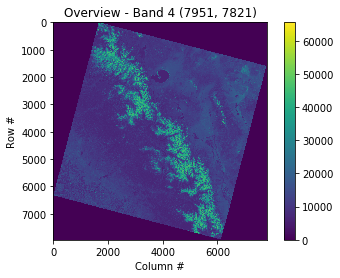

In [114]:
plt.imshow(band1)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(band1.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

`src.transform` returns the georeference of the raster image as an affine transformation term. In order to subset the data with a certain area of interest, you need to convert the geographic coordinates that define the AOI into column and row numbers. Using the affine object this can be done very conveniently. The affine object consists of a six parameters that define the georeference of the band which has been imported as a numpy array. The six parameters [a,b,c,d,e,f] are:

    a = width of a pixel
    b = row rotation (typically zero)
    c = x-coordinate of the upper-left corner of the upper-left pixel
    d = column rotation (typically zero)
    e = height of a pixel (typically negative)
    f = y-coordinate of the of the upper-left corner of the upper-left pixel

![vectorized_tshirt](img/xyrowcol.png)

__Converting from geographic coordinates to image coordinates (row and column number):__

In [120]:
x = 254285.0
y = 4208115
col, row = ~affine * (x, y)
col = int(col)
row = int(row) 

In [121]:
band1[col, row]

37082

__Converting from image coordinates to geographic coordinates:__

In [124]:
col = 43201
row = 76543
x, y = aff * (col, row)

In [125]:
x, y

(1500315.0, 1971825.0)

After the geographic coordinates have been converted to image coordinates you can create a window and pass it to the `read()` function to import only the relevant part of the data.

Text(0, 0.5, 'Row #')

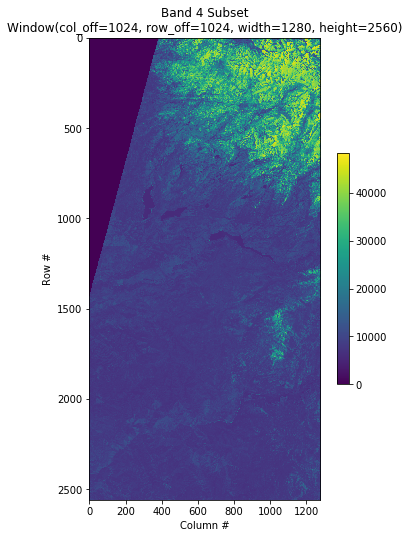

In [8]:
#https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html
#rasterio.windows.Window(col_off, row_off, width, height)
window = rasterio.windows.Window(1024, 1024, 1280, 2560)

with rasterio.open(filepath) as src:
    subset = src.read(1, window=window)

plt.figure(figsize=(6,8.5))
plt.imshow(subset)
plt.colorbar(shrink=0.5)
plt.title(f'Band 4 Subset\n{window}')
plt.xlabel('Column #')
plt.ylabel('Row #')

__Check the docstring of the `read` method to explore other ways of specifying a window.__

## Exercise:
1. Import the near-infrared band from the Landsat imagery as a numpy array.
2. Extract values of the array within the bounding box specified by the following coordinates:

In [148]:
xmin = 254285.0
xmax = 304285.0
ymin = 4108115.0
ymax = 4158115.0

In [149]:
with rasterio.open(filepath) as src:
    affine = src.transform
    col_start, row_start = ~affine * (xmin, ymax)
    col_end, row_end = ~affine * (xmax, ymin)
    print(col_start, row_start)
    print(col_end, row_end)
    band1 = src.read(1, window=((int(row_start), int(row_end)), (int(col_start), int(col_end)) )) # 
band1.shape

1666.666666666666 3666.666666666657
3333.333333333334 5333.333333333343


(1667, 1667)

Text(0, 0.5, 'Row #')

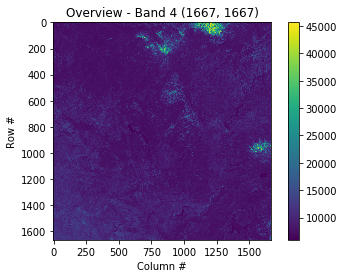

In [151]:
plt.imshow(band1)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(band1.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

Alternatively you can just read the whole band and the slice it using the col and row values.

In [150]:
band_sub = band1[int(row_start):int(row_end), int(col_start):int(col_end)]

## Plot histogram

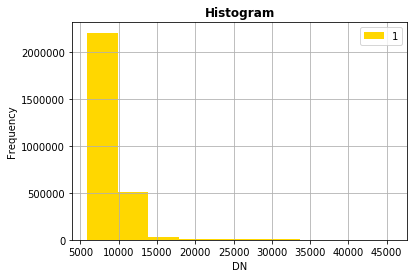

In [155]:
rasterio.plot.show_hist(band1)

### References:
    
https://geohackweek.github.io/raster/04-workingwithrasters/

https://www.earthdatascience.org/workshops/gis-open-source-python/

https://www.perrygeo.com/python-affine-transforms.html

[Switching from GDAL to Rasterio](https://rasterio.readthedocs.io/en/latest/topics/switch.html)

## Summary

* Numpy is great for efficient vectorized computation of raster data. 
* Rasterio helps in keeping track of the georeference. 
* 
